In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from skimage.transform import resize
from tqdm.notebook import tqdm 
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from PIL import Image
import tensorflow as tf
import segmentation_models as sm
from keras import backend as K
from PIL import Image
import keras.utils as image
import imageio
import albumentations as A 
import random

Segmentation Models: using `keras` framework.


In [2]:
# define path input and output images
image_dir = "WSISEG-Database/whole sky images/"
mask_dir = "WSISEG-Database/annotation/" 
image_output_dir = "WSISEG-Database/whole sky images_augmentation3/"
mask_output_dir = "WSISEG-Database/annotation_augmentation3/" 

In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

(450, 480, 3) (450, 480)


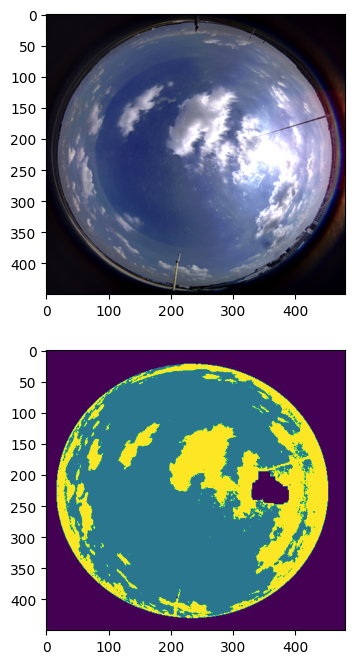

In [4]:
image = cv2.imread(image_dir+"ASC100-1006_001" ,cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_dir+"ASC100-1006_001" ,cv2.IMREAD_GRAYSCALE)
print(image.shape, mask.shape)
original_height, original_width = image.shape[:2]
visualize(image, mask)

In [125]:
np.unique(mask)

array([  0, 100, 255], dtype=uint8)

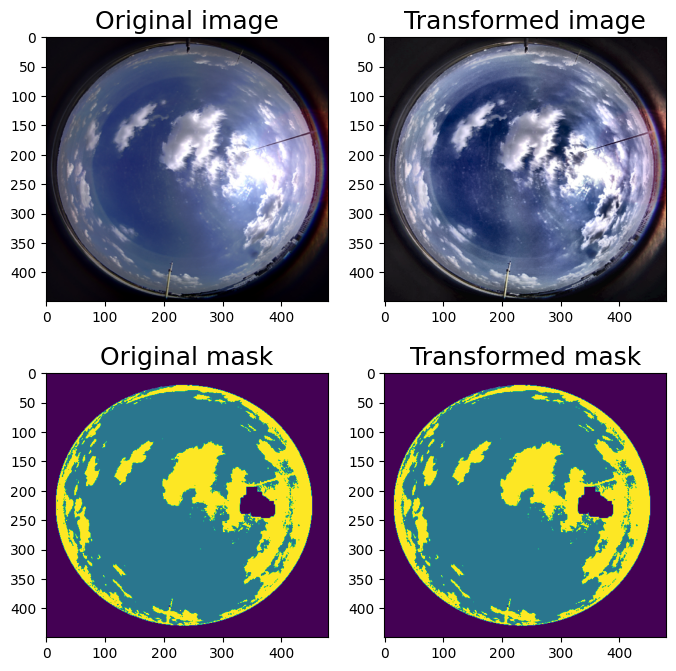

In [117]:
aug = A.CLAHE(p=3.5, always_apply=True)

augmented = aug(image=image, mask=mask)

image_clahe = augmented['image']
mask_clahe = augmented['mask']

visualize(image_clahe, mask_clahe, original_image=image, original_mask=mask)

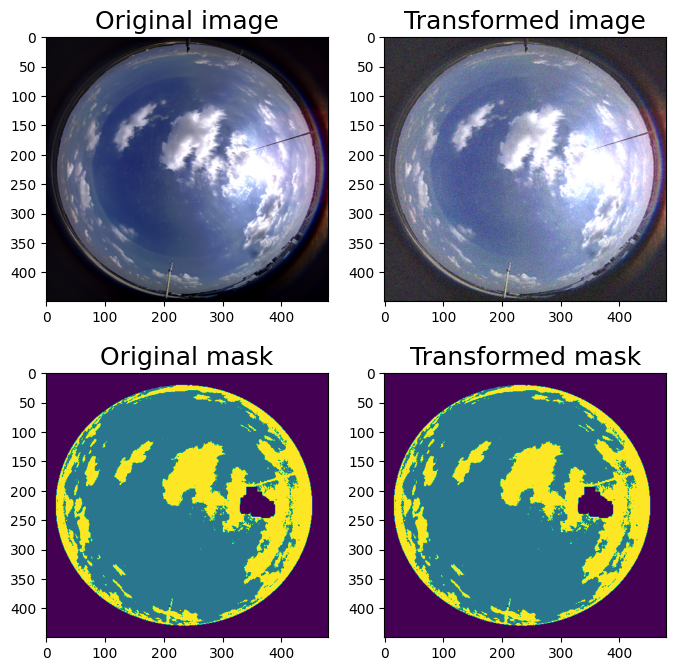

In [118]:
aug = A.GaussNoise(var_limit=(120.0, 150.0), mean=40, p=1, always_apply=True)

augmented = aug(image=image, mask=mask)

image1 = augmented['image']
mask1 = augmented['mask']

visualize(image1, mask1, original_image=image, original_mask=mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


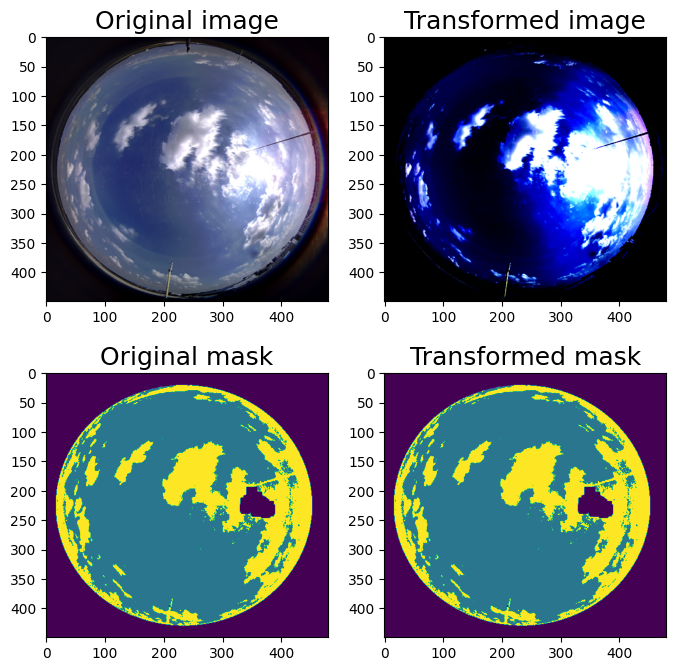

In [119]:
aug = A.Normalize(always_apply=True, p=1)

augmented = aug(image=image, mask=mask)

image2 = augmented['image']
mask2 = augmented['mask']

visualize(image2, mask2, original_image=image, original_mask=mask)

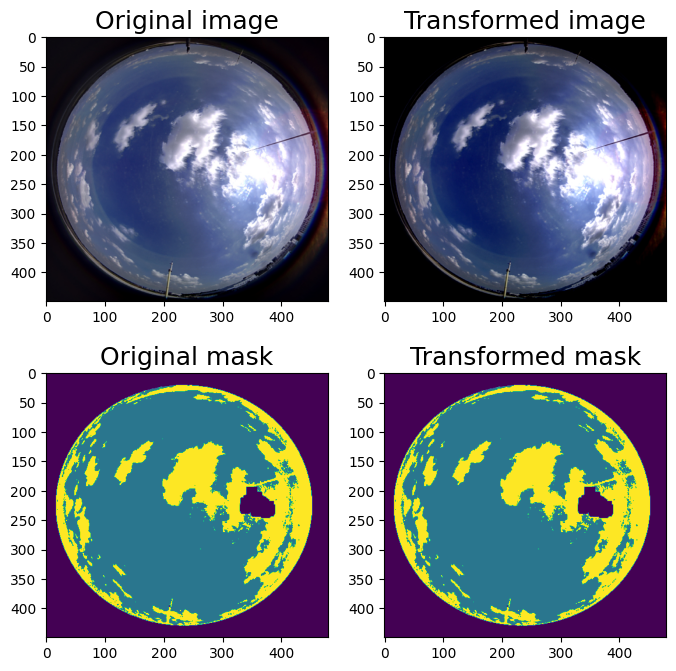

In [120]:
aug = A.RandomBrightnessContrast(p=1)

augmented = aug(image=image, mask=mask)

image3 = augmented['image']
mask3 = augmented['mask']

visualize(image3, mask3, original_image=image, original_mask=mask)

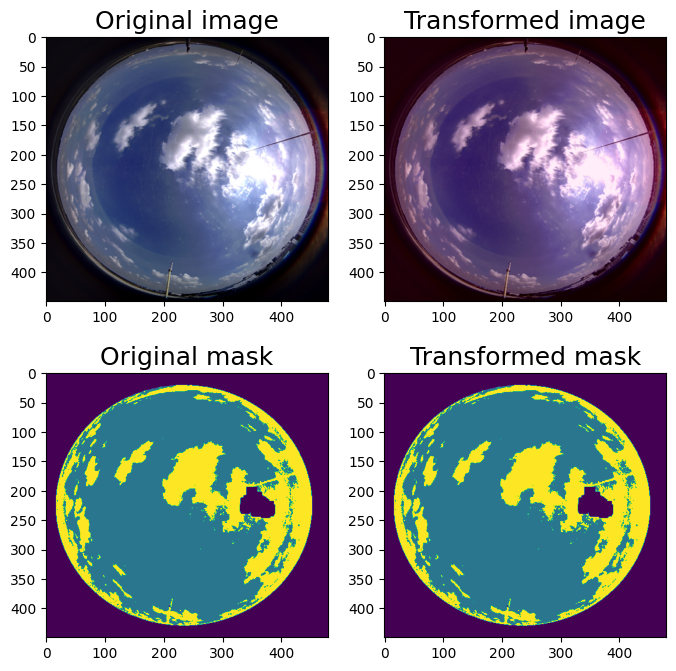

In [121]:
aug = A.RGBShift(p=1)

augmented = aug(image=image, mask=mask)

image3 = augmented['image']
mask3 = augmented['mask']

visualize(image3, mask3, original_image=image, original_mask=mask)

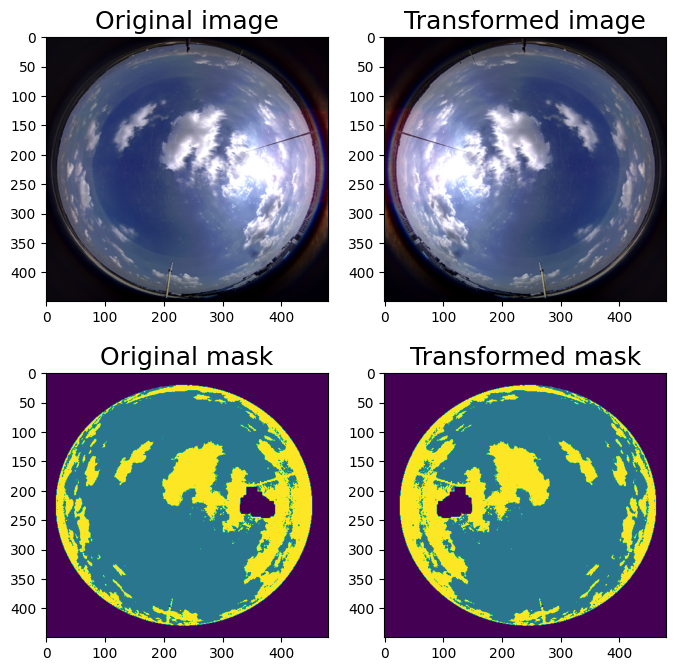

In [151]:
aug = A.geometric.transforms.Flip(p=1)

augmented = aug(image=image, mask=mask)

image3 = augmented['image']
mask3 = augmented['mask']

visualize(image3, mask3, original_image=image, original_mask=mask)

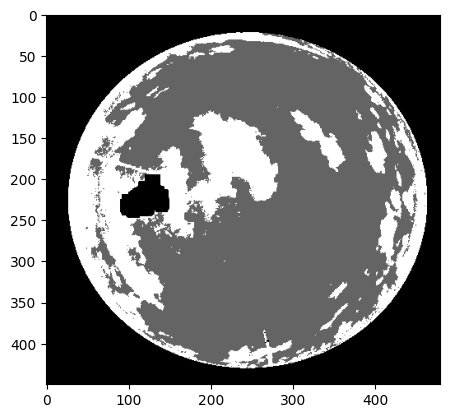

In [137]:
mask = cv2.imread("mask3.png",1)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
plt.imshow(mask)

In [138]:
np.unique(mask)

array([  0, 100, 255], dtype=uint8)

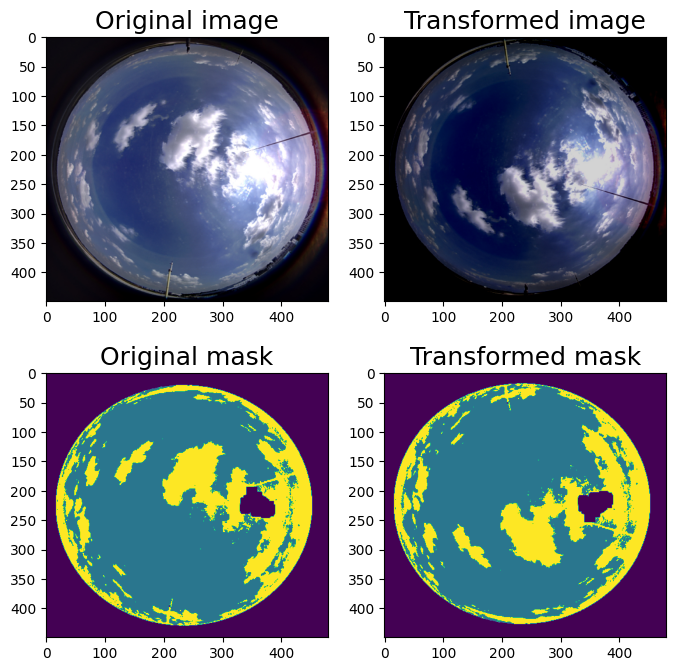

In [5]:
transform = A.Compose([
            A.RandomBrightnessContrast(p=1),
            A.geometric.transforms.Flip(p=1)
        ])

augmented = transform(image=image, mask=mask)

image3 = augmented['image']
mask3 = augmented['mask']

visualize(image3, mask3, original_image=image, original_mask=mask)

In [7]:
# define path input and output images
image_dir = "WSISEG-Database/whole sky images/"
mask_dir = "WSISEG-Database/annotation/" 
image_output_dir = "WSISEG-Database/whole sky images_augmentation3/"
mask_output_dir = "WSISEG-Database/annotation_augmentation3/" 

In [8]:
import shutil

for files in tqdm(os.listdir(image_dir)):
    if files.endswith(".ini"):
        pass
    else:
        transform = A.Compose([
            A.RandomBrightnessContrast(p=1),
            A.geometric.transforms.Flip(p=1)
        ])
        
        # define path
        img = image_dir + files
        mask = mask_dir + files

        # read images
        x = cv2.imread(img, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        y = cv2.imread(mask, 0)

        # augmentations
        aug = A.CLAHE(p=1)
        augmented = aug(image=x, mask=y)
        x1 = augmented['image']
        y1 = augmented['mask']
        
        aug = A.RandomBrightnessContrast(p=1)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']
        
        aug = A.geometric.transforms.Flip(p=1)
        augmented = aug(image=x, mask=y)
        x3 = augmented['image']
        y3 = augmented['mask']
        
        augmented = transform(image=x, mask=y)
        x4 = augmented['image']
        y4 = augmented['mask']
        
        save_images = [x1, x2, x3, x4]
        save_masks = [y1, y2, y3, y4]

        # saving the images and masks
        idx = 0
        for i, m in zip(save_images, save_masks):
            tmp_img_name = f"{files}_augmented_{idx}.jpg"
            tmp_mask_name = f"{files}_augmented_{idx}.png"

            image_path = image_output_dir + tmp_img_name
            mask_path = mask_output_dir + tmp_mask_name
            
            cv2.imwrite(image_path, i[:, :, ::-1])
            cv2.imwrite(mask_path, m)
            ## copy mask becuase their augmentation not effect with mask image
            # shutil.copy2(mask, mask_output_dir)
            # filename = os.path.basename(mask)
            # new_file_path = os.path.join(mask_output_dir, tmp_mask_name)
            # os.rename(os.path.join(mask_output_dir, filename), new_file_path)

            idx+=1

  0%|          | 0/400 [00:00<?, ?it/s]

In [9]:
# define path input and output images
image_dir = "WSISEG-Database/whole sky images/"
mask_dir = "WSISEG-Database/annotation/" 
image_output_dir = "WSISEG-Database/whole sky images_augmentation0/"
mask_output_dir = "WSISEG-Database/annotation_augmentation0/" 

In [10]:
for files in tqdm(os.listdir(image_dir)):
    if files.endswith(".ini"):
        pass
    else:
        # define path
        img = image_dir + files
        mask = mask_dir + files

        # read images
        x = cv2.imread(img, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        y = cv2.imread(mask, 0)

        
        tmp_img_name = f"{files}.jpg"
        tmp_mask_name = f"{files}.png"

        image_path = image_output_dir + tmp_img_name
        mask_path = mask_output_dir + tmp_mask_name
            
        cv2.imwrite(image_path, x[:, :, ::-1])
        cv2.imwrite(mask_path, y)

  0%|          | 0/400 [00:00<?, ?it/s]

### Train test split for train/val/test when train models

In [110]:
image_output_dir = "WSISEG-Database/whole sky images_augmentation/"
mask_output_dir = "WSISEG-Database/annotation_augmentation/"

In [111]:
print("Total images:", len(os.listdir(image_output_dir)))
print("Total masks:", len(os.listdir(mask_output_dir)))

Total images: 1600
Total masks: 1600


In [114]:
n_test = random.sample([i for i in range(len(image_output_dir))], int(0.8*len(image_output_dir)))

In [115]:
n_test

[35,
 17,
 14,
 40,
 43,
 3,
 19,
 6,
 15,
 0,
 41,
 26,
 37,
 12,
 45,
 23,
 33,
 34,
 9,
 29,
 31,
 24,
 44,
 18,
 21,
 25,
 2,
 16,
 42,
 20,
 32,
 13,
 39,
 28,
 5,
 4]